In [74]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sn

In [75]:
# Loading and transposing the dataset

df = pd.read_csv("Train_117.csv")
df = df.T
x = df.iloc[5:,:]

# Loading the labels
labels = pd.read_csv("Train_clinical.csv")
y = labels.iloc[1:,1]

In [3]:
## Implementing random search for hyperparameter tuning

from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid space
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Below takes forever to run. Do not run it if not necessary

In [76]:
## First Nested CV process

# Outer CV
cv_outer = KFold(n_splits=5, shuffle=True, random_state=2)

# Dataframe for the inner CV results

cols = {"n_estimators":[],"min_samples_split":[],"min_samples_leaf":[],"max_features":[],"max_depth":[],"bootstrap":[]}
best_parameters = pd.DataFrame(data=cols)

for i in range(10):
    print("In progress...{}/10".format(i+1))

    for train_ix, test_ix in cv_outer.split(x):
        # Train and test split in the inner cross-validation set
        x_in_train, x_in_test = x.iloc[train_ix, :], x.iloc[test_ix, :]
        y_in_train, y_in_test = y.iloc[train_ix], y.iloc[test_ix]

        # Configure the inner cross-validation procedure
        cv_inner = KFold(n_splits=4, shuffle=True, random_state=i)

        # Define the model
        model = RandomForestClassifier(random_state=i)

        # Define search space
        search = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 50, cv = cv_inner, random_state=i, n_jobs = -1)
        result = search.fit(x_in_train, y_in_train)
        best_model = result.best_estimator_

        # Evaluate model on the hold out dataset
        yhat = best_model.predict(x_in_test)

        # Evaluate the model
        acc = accuracy_score(y_in_test, yhat)

        # Store the result
        print("   Inner loop running...")
        best_parameters = best_parameters.append(result.best_params_,ignore_index = True)
    if i == 9:
        print("Done")

In progress...1/10


NameError: name 'RandomizedSearchCV' is not defined

In [5]:
best_parameters

,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap
0,600.0,5.0,2.0,None,None,1.0
1,1200.0,10.0,1.0,None,None,1.0
2,400.0,10.0,1.0,None,40,1.0
3,400.0,10.0,1.0,None,40,1.0
4,400.0,10.0,1.0,None,40,1.0
5,600.0,10.0,2.0,None,30,0.0
6,1600.0,10.0,2.0,None,90,1.0
7,1400.0,2.0,1.0,None,60,1.0
8,2000.0,10.0,1.0,None,20,1.0
9,1600.0,5.0,1.0,auto,10,1.0


In [6]:
best_parameters.to_csv("RandomSearch_Best_Parameters_hubgenes.csv")

In [7]:
# See the frequency of best hyperparameter in Random Search
for col in best_parameters.columns:
    print(best_parameters[col].value_counts(),"\n")

1200.0    7
1600.0    7
800.0     7
600.0     6
2000.0    6
400.0     5
1400.0    4
1000.0    4
200.0     3
1800.0    1
Name: n_estimators, dtype: int64 

10.0    21
5.0     15
2.0     14
Name: min_samples_split, dtype: int64 

1.0    23
2.0    15
4.0    12
Name: min_samples_leaf, dtype: int64 

auto    4
Name: max_features, dtype: int64 

20     8
100    8
30     4
90     4
110    4
70     4
40     3
10     3
60     2
80     2
50     1
Name: max_depth, dtype: int64 

1.0    44
0.0     6
Name: bootstrap, dtype: int64 



In [8]:
from sklearn.model_selection import GridSearchCV
## Grid Search

# Outer CV
cv_outer = KFold(n_splits=5, shuffle=True, random_state=42)

# enumerate splits
outer_results = list()

for train_ix, test_ix in cv_outer.split(x):
    # Train and test split in the inner cross-validation set
    x_in_train, x_in_test = x.iloc[train_ix, :], x.iloc[test_ix, :]
    y_in_train, y_in_test = y.iloc[train_ix], y.iloc[test_ix]

    # configure the cross-validation procedure
    cv_inner = KFold(n_splits=4, shuffle=True, random_state=42)
    # define the model
    # max_depth and bootstrap are fixed from the most frequent one
    model = RandomForestClassifier(min_samples_split = 10, min_samples_leaf = 1, bootstrap= True, random_state=42)
    
    # define search space based on the frequency above
    # total 6 combination possible
    space = dict()
    space['n_estimators'] = [800, 1200, 1600]
    space['max_depth'] = [20,100]
    # define search
    search = GridSearchCV(model, space, scoring='accuracy', cv=cv_inner, refit=True)
    # execute search
    result = search.fit(x_in_train, y_in_train)
    # get the best performing model fit on the whole training set
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    yhat = best_model.predict(x_in_test)
    # evaluate the model
    acc = accuracy_score(y_in_test, yhat)
    # store the result
    outer_results.append(acc)
    # report progress
    print('>acc=%.3f, est=%.3f, cfg=%s' % (acc, result.best_score_, result.best_params_))

# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

>acc=0.750, est=0.763, cfg={'max_depth': 20, 'n_estimators': 800}
>acc=0.800, est=0.725, cfg={'max_depth': 20, 'n_estimators': 1200}
>acc=0.800, est=0.838, cfg={'max_depth': 20, 'n_estimators': 800}
>acc=0.800, est=0.750, cfg={'max_depth': 20, 'n_estimators': 1600}
>acc=0.800, est=0.788, cfg={'max_depth': 20, 'n_estimators': 1600}
Accuracy: 0.790 (0.020)


In [3]:
# Final model with hand-picked hyperparameters from the 5 best models of outer CV
final_model = RandomForestClassifier(n_estimators = 800, min_samples_split = 10, min_samples_leaf = 1, max_depth = 20, bootstrap = True, random_state = 42)

In [78]:
# Last 5-fold cross-validation to have avearage validation performance
accuracies = list()
accuracies_train = list()
precisions = list()
recalls = list()
sds = list()
for i in range(50):
    final_cv = KFold(n_splits = 5, shuffle = True, random_state = i)
    temp_acc_train = list()
    temp_acc = list()
    for train_ix, test_ix in final_cv.split(x):
        # Train and test split in the inner cross-validation set
        x_in_train, x_in_test = x.iloc[train_ix, :], x.iloc[test_ix, :]
        y_in_train, y_in_test = y.iloc[train_ix], y.iloc[test_ix]

        final_model.fit(x_in_train, y_in_train)
        # get the best performing model fit on the whole training set
        # evaluate model on the hold out dataset
        ytrain = final_model.predict(x_in_train)
        yhat = final_model.predict(x_in_test)
        # evaluate the model
        acc_train = accuracy_score(y_in_train, ytrain)
        acc = accuracy_score(y_in_test, yhat)
        #accuracies_train.append(acc_train)
        #accuracies.append(acc)
        accuracies.append(acc)
        accuracies_train.append(acc_train)
        precisions.append(precision_score(y_in_test, yhat, average = "weighted"))
        recalls.append(recall_score(y_in_test, yhat, average = "weighted"))
    print("In progress...{}/50".format(i+1))

In progress...1/50
In progress...2/50
In progress...3/50
In progress...4/50
In progress...5/50
In progress...6/50
In progress...7/50
In progress...8/50
In progress...9/50
In progress...10/50
In progress...11/50
In progress...12/50
In progress...13/50
In progress...14/50
In progress...15/50
In progress...16/50
In progress...17/50
In progress...18/50
In progress...19/50
In progress...20/50
In progress...21/50
In progress...22/50
In progress...23/50
In progress...24/50
In progress...25/50
In progress...26/50
In progress...27/50
In progress...28/50
In progress...29/50
In progress...30/50
In progress...31/50
In progress...32/50
In progress...33/50
In progress...34/50
In progress...35/50
In progress...36/50
In progress...37/50
In progress...38/50
In progress...39/50
In progress...40/50
In progress...41/50
In progress...42/50
In progress...43/50
In progress...44/50
In progress...45/50
In progress...46/50
In progress...47/50
In progress...48/50
In progress...49/50
In progress...50/50


In [81]:
accuracies_train

[0.9875,
 0.975,
 0.975,
 0.9875,
 0.975,
 0.975,
 0.975,
 0.9875,
 0.9875,
 0.975,
 0.975,
 0.9875,
 0.9875,
 0.975,
 0.975,
 0.9875,
 0.9875,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.9875,
 0.9875,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 1.0,
 0.975,
 0.975,
 0.975,
 0.975,
 0.9875,
 0.975,
 0.975,
 0.9875,
 0.975,
 0.9875,
 0.975,
 0.975,
 0.9875,
 0.975,
 0.9875,
 0.975,
 0.9875,
 0.9875,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.9875,
 0.9875,
 0.975,
 0.975,
 0.9875,
 0.975,
 0.975,
 0.9875,
 0.9875,
 0.975,
 0.975,
 0.975,
 0.975,
 0.9875,
 0.975,
 0.975,
 0.9875,
 0.9875,
 0.975,
 0.975,
 0.975,
 0.9875,
 0.9875,
 0.975,
 0.975,
 0.9875,
 0.975,
 0.975,
 0.975,
 0.975,
 0.975,
 0.9875,
 0.975,
 0.975,
 0.9875,
 0.975,
 0.975,
 0.975,
 0.9875,
 0.975,
 0.975,
 0.9875,
 0.9875,
 0.975,
 0.9875,
 0.975,
 0.975,
 0.9875,
 0.9875,
 0.975,
 0.975,
 0.975,
 0.9875,
 0.975,
 0.9875,
 0.975,
 0.975,
 0.975,
 0.9875,
 0.975,
 0.975,
 0.9875,
 0.9875,
 0.9875,
 0.975,
 0.975,
 0.975,


In [65]:
print("Average accuracy: ",np.mean(accuracies))
print("Average precision: ",np.mean(precisions))
print("Average recall: ", np.mean(recalls))

Average accuracy:  0.7952000000000001
Average precision:  0.8254019624819625
Average recall:  0.7952


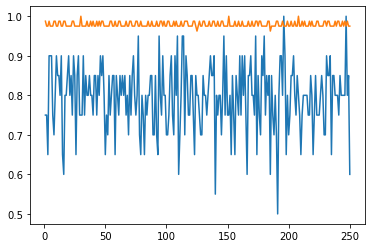

In [56]:
x = np.linspace (1,250,250)
plt.plot(x, accuracies)
plt.plot(x, accuracies_train)

In [66]:
# Final model on raw data

df_raw = pd.read_csv("Train_call.csv")
df_raw = df_raw.T
x_raw = df_raw.iloc[4:,:]

In [82]:
# Last 5-fold cross-validation to have avearage validation performance
accuracies_raw = list()
accuracies_raw_train = list()
precisions_raw = list()
recalls_raw = list()
for i in range(50):
    final_cv = KFold(n_splits = 5, shuffle = True, random_state = i)
    for train_ix, test_ix in final_cv.split(x_raw):
        # Train and test split in the inner cross-validation set
        x_in_train, x_in_test = x_raw.iloc[train_ix, :], x_raw.iloc[test_ix, :]
        y_in_train, y_in_test = y.iloc[train_ix], y.iloc[test_ix]

        final_model.fit(x_in_train, y_in_train)
        # get the best performing model fit on the whole training set
        # evaluate model on the hold out dataset
        yhat = final_model.predict(x_in_test)
        ytrain = final_model.predict(x_in_train)
        # evaluate the model
        acc_train = accuracy_score(y_in_train, ytrain)
        acc = accuracy_score(y_in_test, yhat)
        #accuracies_train.append(acc_train)
        #accuracies.append(acc)
        accuracies_raw.append(acc)
        accuracies_raw_train.append(acc_train)
        precisions_raw.append(precision_score(y_in_test, yhat, average = "weighted"))
        recalls_raw.append(recall_score(y_in_test, yhat, average = "weighted"))
    print("In progress...{}/50".format(i+1))

In progress...1/50
In progress...2/50
In progress...3/50
In progress...4/50
In progress...5/50
In progress...6/50
In progress...7/50
In progress...8/50
In progress...9/50
In progress...10/50
In progress...11/50
In progress...12/50
In progress...13/50
In progress...14/50
In progress...15/50
In progress...16/50
In progress...17/50
In progress...18/50
In progress...19/50
In progress...20/50
In progress...21/50
In progress...22/50
In progress...23/50
In progress...24/50
In progress...25/50
In progress...26/50
In progress...27/50
In progress...28/50
In progress...29/50
In progress...30/50
In progress...31/50
In progress...32/50
In progress...33/50
In progress...34/50
In progress...35/50
In progress...36/50
In progress...37/50
In progress...38/50
In progress...39/50
In progress...40/50
In progress...41/50
In progress...42/50
In progress...43/50
In progress...44/50
In progress...45/50
In progress...46/50
In progress...47/50
In progress...48/50
In progress...49/50
In progress...50/50


In [84]:
accuracies_raw_train

[0.975,
 0.975,
 0.975,
 0.9875,
 0.9625,
 0.9875,
 0.975,
 0.975,
 0.975,
 0.9625,
 0.975,
 0.975,
 0.975,
 0.975,
 0.9625,
 0.975,
 0.975,
 0.9625,
 0.9625,
 0.975,
 0.9875,
 0.9625,
 0.975,
 0.9875,
 0.9625,
 0.975,
 0.975,
 0.9625,
 0.9875,
 0.9875,
 0.9625,
 1.0,
 0.975,
 0.9625,
 0.9875,
 1.0,
 1.0,
 0.975,
 0.975,
 0.975,
 0.975,
 0.9625,
 0.975,
 0.9875,
 0.975,
 0.9625,
 0.975,
 0.975,
 0.9625,
 0.9875,
 0.9625,
 0.9625,
 0.9875,
 0.975,
 0.975,
 0.975,
 0.9875,
 0.9875,
 0.9625,
 0.9625,
 0.975,
 0.975,
 0.975,
 0.975,
 0.9625,
 0.9625,
 0.975,
 0.975,
 0.9875,
 1.0,
 1.0,
 0.975,
 0.975,
 0.9625,
 0.975,
 0.9875,
 0.9625,
 0.9625,
 0.9875,
 0.9625,
 0.975,
 0.9625,
 0.9875,
 0.975,
 0.975,
 0.9625,
 0.9875,
 0.9875,
 0.9625,
 0.9875,
 0.9625,
 0.975,
 0.9875,
 0.9625,
 0.975,
 0.975,
 0.9875,
 0.975,
 0.9625,
 1.0,
 0.9875,
 0.975,
 0.975,
 1.0,
 0.9625,
 0.975,
 0.9625,
 0.975,
 0.9625,
 1.0,
 0.9625,
 0.9875,
 0.975,
 0.9875,
 0.975,
 0.975,
 0.975,
 0.975,
 0.9625,
 1.0,


In [73]:
print("Average accuracy: ",np.mean(accuracies_raw))
print("Average precision: ",np.mean(precisions_raw))
print("Average recall: ", np.mean(recalls_raw))

Average accuracy:  0.7092
Average precision:  0.7539320068820069
Average recall:  0.7092
